# Graph Signal Processing using TV regularization

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, plotting
from sklearn.metrics import mean_squared_error
import pyunlocbox
from random import random
from IPython.display import display, clear_output

from scipy.spatial.distance import pdist, cdist, squareform

DATA_PATH = '../data/ml-100k-convert/'
GENERATED_PATH = '../generated/'
RESULT_PATH = '../results/'
adjacency = np.loadtxt(GENERATED_PATH+'movie_ratings_adj.csv', delimiter=',')
ratings = pd.read_csv(GENERATED_PATH+'ratings_matrix.csv', index_col=0)

## Total variation regularization

The approach we take to solve the movie recommandation system is that each set of ratings coming from a user is a signal lying on the graph of movies previously constructed.

The problem is that a lot of ratings are missing. The known ratings are between 1 and 5 and the unknown ratings are equal to 0.

We try to reconstruct the signal of the ratings for all movies using a TV regularization method. Indeed because the signal of ratings is a picewise constant function it is the most appropriate approach to recover the signal.

The TV regularization method try to recover the signal $x$ by solving the optimization problem :

$$
\tilde{x}=\underset{x \in \mathbb{R}^{N}}{\arg \min } \left\{ \|A x-y\|_{2}^{2}+R_{\mathrm{tv}}(x ; G) \right\}
$$

where $R_{\mathrm{tv}}(x ; G)=\alpha\|S x\|_{1}=\alpha \sum_{w_{i j} \in E} \sqrt{w_{i j}}|x(i)-x(j)|$

## Using Movie Ratings Graph
### Small network

To begin we just use the first signal (the first user)

In [75]:
ratings[ratings > 0].count(axis=1).sort_values(ascending=False)

UserId
13     304
276    293
416    270
655    270
303    262
      ... 
300     10
242      9
565      7
558      7
855      4
Length: 943, dtype: int64

In [76]:
mean_counter = ratings.copy().astype('float')
mean_counter[mean_counter == 0] = np.nan
mean_signal = np.nanmean(mean_counter, axis = 0)

In [77]:
signal = ratings.loc[13].reset_index(drop = True)
indexes = np.array(signal[signal >0].index.to_list())

We use the first 161 movies which are all rated by this user. So we can see the evolution of the MSE with the percentage of missing ratings

In [78]:
adj = adjacency[indexes][:, indexes]
signal = signal[indexes]
mean_sig = mean_signal[indexes]
G = graphs.Graph(adj)
G.set_coordinates()

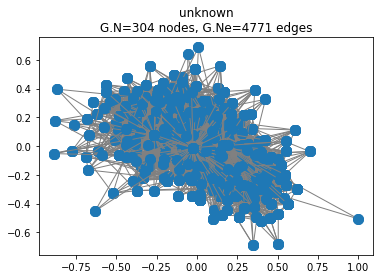

In [79]:
# Load graph
G = graphs.Graph(adj)
G.set_coordinates()
G.plot()

In [80]:
# This function solve the optimization problem of the TV regularization
def tv_reg(G, noisy, mask, gamma = 3):
    # Set the functions in the problem
    d = pyunlocbox.functions.dummy()
    r = pyunlocbox.functions.norm_l1()
    f = pyunlocbox.functions.norm_l2(w=mask, y=noisy, lambda_=gamma)

    # Define the solver
    G.compute_differential_operator()
    L = G.D.toarray()
    step = 0.999 / (1 + np.linalg.norm(L))
    solver = pyunlocbox.solvers.mlfbf(L=L, step=step)

    # Solve the problem
    x0 = noisy.copy()
    prob1 = pyunlocbox.solvers.solve([d, r, f], solver=solver, x0=x0, rtol=0, maxit=1000, verbosity='NONE')

    return prob1['sol']

In [81]:
# Create the mask
rs = np.random.RandomState(41)
mask = rs.rand(G.N)
mask = (mask < 0.7).astype(float)
inverse_mask = mask * -1 + 1
noisy = signal * mask
noisy = noisy + mean_sig * (mask * -1 + 1)

print(inverse_mask)
test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.]


We perform a validation test for the parameter gamma

1.0 1.2271819827241193
1.2181879120101156 1.0854342410937903
1.4839817889675653 0.9763568716493817
1.8077686769634342 0.8776687953962076
2.202201949987375 0.8060566136378302
2.682695795279726 0.7521380419377882
3.268027589410125 0.7035477459359124
3.9810717055349722 0.6830941370631114
4.849693428528198 0.6617007260590932
5.907837911587945 0.6411020763139117
7.196856730011521 0.6294155984395311
8.767123872968682 0.6234982847035119
10.680004325145754 0.6196144801188467
13.010252169108314 0.6160531239310463
15.848931924611133 2.5841396591085743
Best gamma :  13.010252169108314
RMSE :  0.6160531239310463


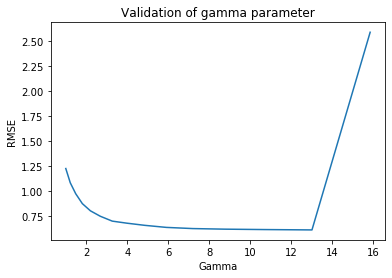

In [82]:
# Reconstruct the signal
errors = []
best_error = np.inf
best_gamma = 0
gamma_range = np.logspace(-0,1.2,15)
for gamma in gamma_range:
    reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=gamma), 1, 5)

    test_reconstructed = reconstructed * inverse_mask
    test_reconstructed = test_reconstructed[test_reconstructed != 0]
    error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
    print(gamma, error)
    if error < best_error:
        best_error = error
        best_gamma = gamma
    errors.append(error)

# we compute the mean squared error only between the ratings we didn't know
print("Best gamma : ", best_gamma)
print("RMSE : ", best_error)

plt.figure()
plt.plot(gamma_range, errors)
plt.title("Validation of gamma parameter")
plt.xlabel("Gamma")
plt.ylabel("RMSE")
plt.show()

In [83]:
reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=best_gamma), 1, 5)
print(f'the best gamma is {best_gamma}')

the best gamma is 13.010252169108314


/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


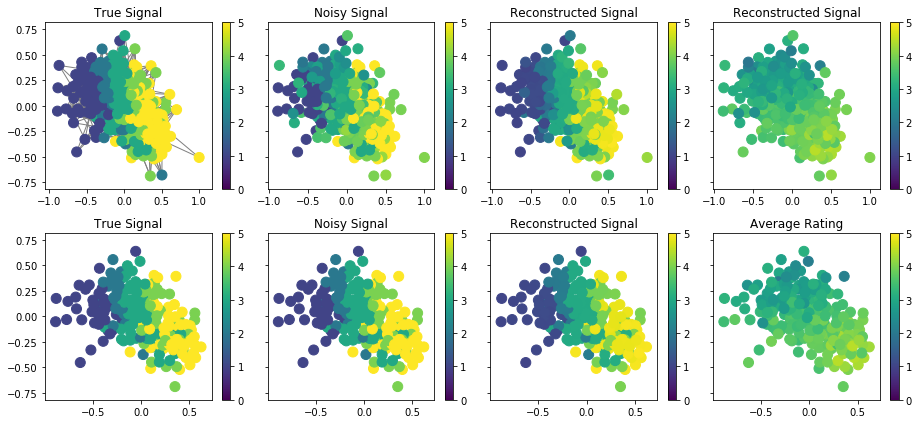

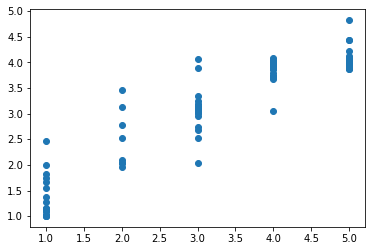

In [84]:
fig, [(ax1, ax2, ax3, ax4),(axl1,axl2,axl3, axl4)] = plt.subplots(2, 4, sharey=True, figsize=(13, 6))
limits = [0, 5]
_ = G.plot_signal(signal, ax=ax1, limits=limits, plot_name='True Signal')
_ = G.plot_signal(noisy, ax=ax2, limits=limits, plot_name='Noisy Signal', show_edges = False)
_ = G.plot_signal(reconstructed, ax=ax3, limits=limits, plot_name='Reconstructed Signal', show_edges= False)
_ = G.plot_signal(mean_sig, ax=ax4, limits=limits, plot_name='Reconstructed Signal', show_edges= False)

signal_red = signal.copy()
signal_red[mask == 0] = np.nan
noisy_red = noisy.copy()
noisy_red[mask == 0] = np.nan
reconstructed_red = reconstructed.copy()
reconstructed_red[mask == 0] = np.nan
mean_signal_red = mean_sig.copy()
mean_signal_red[mask == 0] = np.nan

_ = G.plot_signal(signal_red, ax=axl1, limits=limits, plot_name='True Signal', show_edges = False)
_ = G.plot_signal(noisy_red, ax=axl2, limits=limits, plot_name='Noisy Signal', show_edges = False)
_ = G.plot_signal(reconstructed_red, ax=axl3, limits=limits, plot_name='Reconstructed Signal', show_edges = False)
_ = G.plot_signal(mean_signal_red, ax=axl4, limits=limits, plot_name='Average Rating', show_edges = False)

_ = fig.tight_layout()

plt.show()
plt.scatter(signal[mask == 0], reconstructed[mask == 0])

In [85]:

np.count_nonzero(~np.isnan(reconstructed_red))

214

We will compare this results whith a dummy program which always return 3

In [86]:
test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

test_reconstructed = np.ones(len(signal)) * inverse_mask * np.mean(signal)
test_reconstructed = test_reconstructed[test_reconstructed != 0]

# we compute the mean squared error only between the ratings we didn't know
dummy_error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
print("Dummy RMSE : ", dummy_error)

Dummy RMSE :  1.475876622741737


We perform better than the dummy program !

In [87]:
test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

test_reconstructed = inverse_mask * mean_sig
test_reconstructed = test_reconstructed[test_reconstructed != 0]

# we compute the mean squared error only between the ratings we didn't know
dummy_error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
print("Dummy RMSE : ", dummy_error)

Dummy RMSE :  1.3043941064695905


Now let's look at how the RMSE evolve with the percentage of missing value.

(0, 0) 0.368, 1.789, 1.817
(0, 1) 0.695, 1.388, 1.090
(0, 2) 0.704, 1.279, 1.133
(0, 3) 0.621, 1.383, 1.243
(0, 4) 0.590, 1.380, 1.255
(0, 5) 0.732, 1.389, 1.248
(0, 6) 0.882, 1.380, 1.298
(0, 7) 1.172, 1.377, 1.277
(0, 8) 1.325, 1.410, 1.305
(0, 9) 1.476, 1.393, 1.263
(1, 0) 0.515, 1.002, 0.728
(1, 1) 0.589, 1.450, 1.272
(1, 2) 0.563, 1.370, 1.285
(1, 3) 0.585, 1.432, 1.287
(1, 4) 0.700, 1.402, 1.224
(1, 5) 0.861, 1.406, 1.340
(1, 6) 0.951, 1.377, 1.286
(1, 7) 1.260, 1.410, 1.279
(1, 8) 1.373, 1.370, 1.248
(1, 9) 1.399, 1.391, 1.267
(2, 0) 0.701, 1.195, 0.805
(2, 1) 0.698, 1.575, 1.441
(2, 2) 0.550, 1.338, 1.211
(2, 3) 0.606, 1.468, 1.350
(2, 4) 0.568, 1.369, 1.225
(2, 5) 0.783, 1.389, 1.271
(2, 6) 0.896, 1.398, 1.264
(2, 7) 0.998, 1.368, 1.274
(2, 8) 1.383, 1.405, 1.290
(2, 9) 1.503, 1.386, 1.243
(3, 0) 0.925, 1.427, 1.529
(3, 1) 0.627, 1.247, 1.217
(3, 2) 0.688, 1.310, 1.142
(3, 3) 0.570, 1.366, 1.244
(3, 4) 0.647, 1.335, 1.227
(3, 5) 0.709, 1.405, 1.307
(3, 6) 0.853, 1.365, 1.234
(

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(9, 9) 1.475, 1.398, 1.273


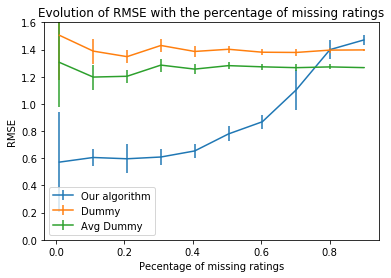

In [88]:
missing = np.linspace(0.01, 0.9, 10)
n_random = 10
errors = np.zeros(shape=(n_random, len(missing)))
errors_dummy = np.zeros(shape=(n_random, len(missing)))
errors_avg = np.zeros(shape=(n_random, len(missing)))
for i in range(n_random):
    rs = np.random.RandomState()
    for j, missing_percentage in enumerate(missing):
        # Create the mask
        mask = rs.rand(G.N)
        mask = (mask > missing_percentage).astype(float)
        noisy = signal * mask
        noisy = noisy + mean_sig * (mask * -1 + 1)
        # Compute errors
        inverse_mask = mask * -1 + 1

        test_true = signal * inverse_mask
        
        test_true = test_true[test_true != 0]

        reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=best_gamma), 1, 5)
        test_reconstructed = reconstructed * inverse_mask
        test_reconstructed = test_reconstructed[test_reconstructed != 0]
        errors[i,j] = np.sqrt(mean_squared_error(test_true, test_reconstructed))
        
        test_dummy = np.ones(len(signal)) * inverse_mask * np.mean(signal)
        test_dummy = test_dummy[test_dummy != 0]
        errors_dummy[i,j] = np.sqrt(mean_squared_error(test_true, test_dummy))
        
        avg_dummy = inverse_mask * mean_sig
        avg_dummy = avg_dummy[avg_dummy != 0]
        errors_avg[i,j] = np.sqrt(mean_squared_error(test_true, avg_dummy))
        print(f'{i,j} {(errors[i,j]):.3f}, {(errors_dummy[i,j]):.3f}, {(errors_avg[i,j]):.3f}')
        

plt.figure()
plt.errorbar(missing, np.mean(errors, axis=0), yerr=np.std(errors, axis=0), label="Our algorithm")
plt.errorbar(missing, np.mean(errors_dummy, axis=0), yerr=np.std(errors_dummy, axis=0), label="Dummy")
plt.errorbar(missing, np.mean(errors_avg, axis=0), yerr=np.std(errors_dummy, axis=0), label="Avg Dummy")
plt.ylim([0,1.6])
#plt.plot(missing, np.ones(len(missing))*dummy_error, label= "Pseudo dummy error")
plt.legend()
plt.title("Evolution of RMSE with the percentage of missing ratings")
plt.xlabel("Pecentage of missing ratings")
plt.ylabel("RMSE")
plt.savefig(RESULT_PATH+'evolution_rmse_missing.eps')
plt.show()

We can see that 

## Entire network

### Test with one user

We will now try with the whole network (still for the first user). The principle is really the same but we have to carefully design the mask. Indeed the mask must be 0 for every unknown entry and 30% of known entry and 1 elsewhere.

In [89]:
def user_weight_simple(ratingsA, ratingsB):
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = np.abs((ratingsA[mask] - ratingsB[mask]))
    return np.sum(4 - diff_ratings) / (np.count_nonzero(ratingsA))


weight_matrix = (cdist(ratings.to_numpy(), ratings.to_numpy(), user_weight_simple))



In [90]:
u_ii = 2
signal = ratings.loc[u_ii]


In [91]:
# Laod graph
G = graphs.Graph(adjacency)
G.set_coordinates()

In [92]:
def create_mask(signal, valid_percent, test_percent):
    mask = np.zeros(len(signal))
    validation_mask = np.zeros(len(signal))
    test_mask = np.zeros(len(signal))
    for i in range(len(signal)):
        if signal[i] != 0:
            x = random()
            if x < test_percent:
                test_mask[i] = 1
            elif x < test_percent + valid_percent:
                validation_mask[i] = 1
            else:
                mask[i] = 1
    return mask, validation_mask, test_mask

In [93]:
# create mask
mask, validation_mask, test_mask = create_mask(signal, 0.2, 0.2)
noisy_validation = signal * mask
noisy_validation = noisy_validation + mean_signal * (mask * -1 + 1)
validation_true = signal * validation_mask
validation_true = validation_true[validation_true != 0]

In [94]:
errors = []
best_error = np.inf
best_gamma = 0
interval = np.linspace(4, 8,2)

for gamma in interval:
    reconstructed = np.clip(tv_reg(G, noisy_validation, mask, gamma=gamma), 1, 5)
    
    if(np.isnan(reconstructed).any()):
        errors.append(0)
        continue
    # Compute errors
    validation_reconstructed = reconstructed * validation_mask
    validation_reconstructed = validation_reconstructed[validation_reconstructed != 0]
    error = np.sqrt(mean_squared_error(validation_true, validation_reconstructed))
    print(gamma, error)
    if error < best_error:
        best_error = error
        best_gamma = gamma

    errors.append(error)

4.0 1.262751706200536
8.0 1.2489409721002278


Best gamma :  6
Validation RMSE :  1.2489409721002278
Test RMSE :  1.0678346097641944


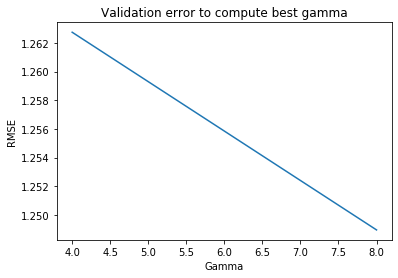

In [95]:
# retrain using train and validation data
mask += validation_mask
best_gamma = 6
noisy_test = signal * mask
noisy_test = noisy_test + mean_signal * (mask * -1 + 1)
reconstructed = np.clip(tv_reg(G, noisy_test, mask, gamma=best_gamma), 1, 5)

test_true = signal * test_mask
test_true = test_true[test_true != 0]

test_reconstructed = reconstructed * test_mask
test_reconstructed = test_reconstructed[test_reconstructed != 0]
print("Best gamma : ", best_gamma)
print("Validation RMSE : ", best_error)
print("Test RMSE : ", np.sqrt(mean_squared_error(test_true, test_reconstructed)))

plt.figure()
plt.plot(interval, errors)
plt.title("Validation error to compute best gamma")
plt.xlabel("Gamma")
plt.ylabel("RMSE")
plt.show()

In [96]:
def predictRating(user_corr, ratings ):
    rating_mask = (ratings != 0).astype(float)
    #user_corr = np.random.rand(user_corr.shape[0])
    #user_corr = np.random.rand(user_corr.shape[0])
    user_corr = user_corr
    #user_corr[user_corr == 4] = 0
    #np.kron(user_corr[:4])
    #user_corr[:4].shape)
    user_corr_expand = (np.ones((ratings.shape[1],1)) @ (user_corr.reshape((1,user_corr.shape[0])))).T * rating_mask 
    user_corr_exp_norm = user_corr_expand / (user_corr_expand.sum(axis=0)[np.newaxis, :] + 1E-10)
    user_corr_exp_norm[np.isnan(user_corr_exp_norm)] = 0
    weighted_ratings = ratings * user_corr_exp_norm
    pred_ratings = weighted_ratings.sum(axis = 0)
    return pred_ratings

errors = []
pred_rating = predictRating(weight_matrix[u_ii - 1,:].copy(), ratings.to_numpy())
#     #pred_rating = predictRating(np.random.rand(nn_weight_mat.shape[0]), ratings_np)
ratings_user = ratings.to_numpy()[u_ii - 1 ,:]
test_pred = pred_rating * test_mask
test_pred = test_pred[test_pred != 0]
errors.append(np.sqrt(mean_squared_error(test_true, test_pred)))
#errors.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0],(1+ 4 * np.random.rand(np.count_nonzero(ratings_user))))))
#     if ii % 300 == 0:
print(np.average(errors))

0.6381934941364793


In [97]:
#reconstructed = np.clip(tv_reg(G, noisy_validation, mask, gamma=best_gamma), 1, 5)

/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


(480,) (480,) (480,)
(480,)


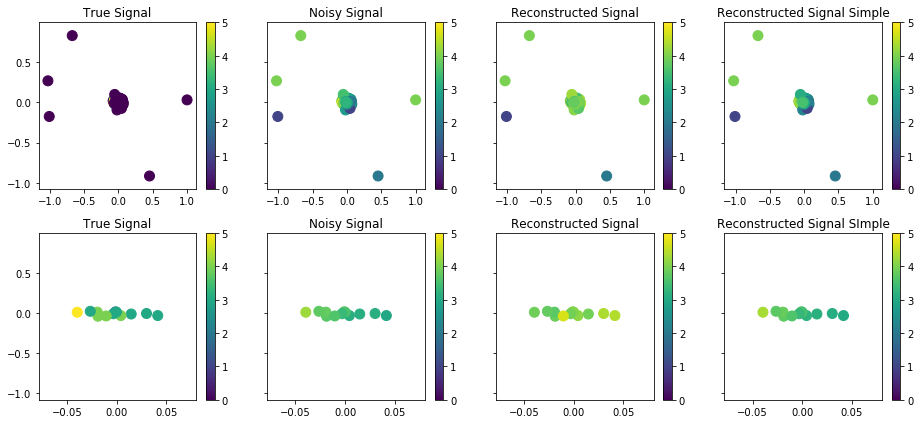

In [98]:
fig, [(ax1, ax2, ax3, ax4), (axl1, axl2, axl3, axl4)] = plt.subplots(2, 4, sharey=True, figsize=(13, 6))
limits = [0, 5]
_ = G.plot_signal(signal, ax=ax1, limits=limits, plot_name='True Signal')
_ = G.plot_signal(noisy_test, ax=ax2, limits=limits, plot_name='Noisy Signal')
_ = G.plot_signal(reconstructed, ax=ax3, limits=limits, plot_name='Reconstructed Signal')
_ = G.plot_signal(pred_rating, ax=ax4, limits=limits, plot_name='Reconstructed Signal Simple')

print(signal.shape, noisy_test.shape, reconstructed.shape)
print(validation_mask.shape)
signal_red = signal.copy()
signal_red[test_mask == 0] = np.nan
noisy_red = noisy_test.copy()
noisy_red[test_mask  == 0] = np.nan
reconstructed_red = reconstructed.copy()
reconstructed_red[test_mask == 0] = np.nan
pred_rating_red = pred_rating.copy()
pred_rating_red[test_mask == 0] = np.nan

_ = G.plot_signal(signal_red, ax=axl1, limits=limits, plot_name='True Signal', show_edges = False)
_ = G.plot_signal(noisy_red, ax=axl2, limits=limits, plot_name='Noisy Signal', show_edges = False)
_ = G.plot_signal(reconstructed_red, ax=axl3, limits=limits, plot_name='Reconstructed Signal', show_edges = False)
_ = G.plot_signal(pred_rating_red, ax=axl4, limits=limits, plot_name='Reconstructed Signal SImple', show_edges = False)

_ = fig.tight_layout()

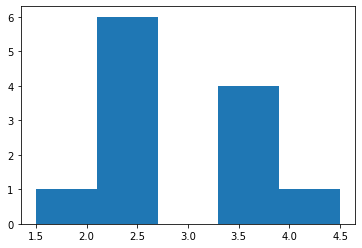

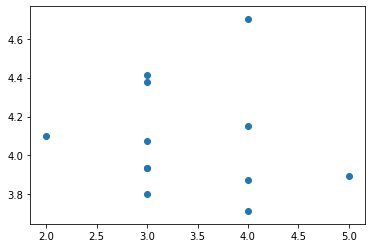

In [99]:
# signal_red[] = signal.copy()
# signal_red[test_mask == 0] = np.nan
# noisy_red = noisy_test.copy()
# noisy_red[test_mask == 0] = np.nan
# reconstructed_red = reconstructed.copy()
# reconstructed_red[test_mask == 0] = np.nan
#print(signal[test_mask != 0])
plt.hist(signal[test_mask != 0] - 0.5,bins=5)
plt.show()
plt.scatter(signal[test_mask == 1], reconstructed[test_mask == 1])

### Test over all users
Now we will test the TV regularization over all users. Each of them reprensent a signal lying on the graph. We will use a test set of 30% of the rated movie for all users

Fast test for all users

In [100]:
def user_weight_simple(ratingsA, ratingsB):
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = np.abs((ratingsA[mask] - ratingsB[mask]))
    return np.sum(4 - diff_ratings) / (np.count_nonzero(ratingsA))


weight_matrix = (cdist(ratings.to_numpy(), ratings.to_numpy(), user_weight_simple))

557

1.1310133319811102

0.9770461839586201

0.9788236128707183

0.0

[0.20882122568468178, 0.8108940639789597, 1.150757965977417]

[1.1250281060127323, 1.0286457202690535, 1.0862812850468002]

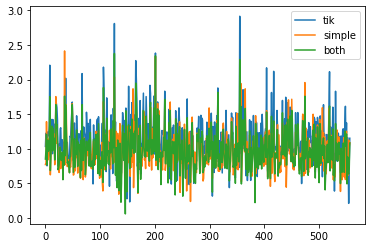

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [101]:
# Laod graph
G = graphs.Graph(adjacency)
G.set_coordinates()

errors_tik = []
errors_simple_diff = []
errors_simple = []
errors_both = []

for idx, signal in ratings.iterrows():
    mask, validation_mask, test_mask = create_mask(signal, 0.0, 0.3)
    
    
    noisy = signal * mask
    noisy = noisy + mean_signal * (mask * -1 + 1)
    
    
    reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=8), 1, 5)
    
    test_true = signal * test_mask
    test_true = test_true[test_true != 0]
    
    test_reconstructed = reconstructed * test_mask
    test_reconstructed = test_reconstructed[test_reconstructed != 0]
    
    error =  np.sqrt(mean_squared_error(test_true, test_reconstructed))
    
    errors_tik.append(error)
    
    #-----
    pred_rating = predictRating(weight_matrix[u_ii - 1,:].copy(), ratings.to_numpy())
    
    ratings_user = ratings.to_numpy()[u_ii - 1 ,:]
    test_pred = pred_rating * test_mask
    test_pred = test_pred[test_pred != 0]
    
    test_true3 = ratings_user * test_mask
    test_true3 = test_true[test_true != 0]
    
    errors_simple.append(np.sqrt(mean_squared_error(test_true, test_pred)))
    errors_simple_diff.append(errors_simple[-1] - np.sqrt(mean_squared_error(test_true3, test_pred)))
    
    # ----
    
    errors_both.append(np.sqrt(mean_squared_error(test_true, (test_pred + test_reconstructed) / 2)))
    

    clear_output(wait=True)
    display(idx, np.mean(errors_tik), np.mean(errors_simple), np.mean(errors_both), np.mean(errors_simple_diff), errors_tik[-3:],  errors_simple[-3:])
    plt.plot(errors_tik, label = 'tik')
    plt.plot(errors_simple, label = 'simple')
    plt.plot(errors_both, label = 'both')
    plt.legend()
    plt.savefig((RESULT_PATH+'evolution_RMSE_tik_simple.pdf'))
    plt.show()

In [ ]:
plt.plot(sorted(errors_tik), label = 'tik')
plt.plot(sorted(errors_simple), label = 'simple')
plt.plot(sorted(errors_both), label = 'both')

slower test for all users 

In [ ]:
test_errors = []
best_gammas = []
percentage_data = []
for idx, signal in ratings.iterrows():
    # create mask
    mask, validation_mask, test_mask = create_mask(signal, 0.2, 0.2)
    #print(G.N, np.count_nonzero(signal))
    noisy_validation = signal * mask
    noisy_validation = noisy_validation + mean_signal * (mask * -1 + 1)
    errors = []
    best_error = np.inf
    best_gamma = 0
    interval = np.linspace(4,11,3)
    for gamma in interval:
        reconstructed = np.clip(tv_reg(G, noisy_validation, mask, gamma=gamma), 1, 5)

        # Compute errors
        validation_true = signal * validation_mask
        validation_true = validation_true[validation_true != 0]

        validation_reconstructed = reconstructed * validation_mask
        validation_reconstructed = validation_reconstructed[validation_reconstructed != 0]
        error = mean_squared_error(validation_true, validation_reconstructed)
        display(error)
        if error < best_error:
            best_error = error
            best_gamma = gamma
        errors.append(error)

    # retrain using train and validation data
    mask += validation_mask
    noisy_test = signal * mask
    reconstructed = np.clip(tv_reg(G, noisy_test, mask, gamma=best_gamma), 1, 5)

    test_true = signal * test_mask
    test_true = test_true[test_true != 0]

    test_reconstructed = reconstructed * test_mask
    test_reconstructed = test_reconstructed[test_reconstructed != 0]
    
    test_error = mean_squared_error(test_true, test_reconstructed)
    print(test_error)
    plt.scatter(signal[test_mask == 1], reconstructed[test_mask == 1])
    plt.ylim(0.5,5.5)
    plt.xlim(0.5,5.5)
    plt.savefig(f'{RESULT_PATH}/Correlation/{idx}.png')
    
    plt.show()
    
    best_gammas.append(best_gamma)
    test_errors.append(test_error)
    percentage_data.append(len(noisy_test[noisy_test != 0])/len(signal))
    clear_output(wait=True)
    display(f'{np.mean(best_gammas)},{np.std(best_gammas)}')

## Using Movie feature Graph

In this section @Lukas you can do the same analysis but using the movie feature graph